**Texturerkennung**  
*Datenbasis: Brodatz Texturen*  
*Klassifizierer: Gaussian Naive Bayes*  

Brodatz Texture Database besteht aus 112 Bildern von Texturen mit schwarzem oder grauen Hintergrund.
https://multibandtexture.recherche.usherbrooke.ca/original_brodatz_more.html 

Gaussian Naive Bayes ist ein Klassifizierer, der auf dem Bayes Theorem basiert und von einer Gaußschen Normalverteilung der Daten ausgeht. https://iq.opengenus.org/gaussian-naive-bayes/ 

In [28]:
import os
from natsort import natsorted, ns
import numpy as np
import random
from scipy import ndimage as ndi
from skimage import io
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from sklearn.model_selection import train_test_split
from skimage.transform import rotate


# Texturdatensatz laden
list_files = os.listdir('./brodatz')
list_files = natsorted(list_files)
image_list = [io.imread("./brodatz/" + filename) for filename in list_files]

# Größeren Datensatz erzeugen, durch rotieren der Bilder und Label hinzufügen
image_list_new = [(image_list[image], image) for image in range(len(image_list))]
image_list_rot90 = [(rotate(image_list[image],90), image) for image in range(len(image_list))]
image_list_rot180 = [(rotate(image_list[image],180), image) for image in range(len(image_list))]
image_list_rot270 = [(rotate(image_list[image],270), image) for image in range(len(image_list))]

big_list = image_list_new + image_list_rot90 + image_list_rot180 + image_list_rot270 + image_list_new + image_list_rot90 + image_list_rot180 + image_list_rot270 + image_list_new + image_list_rot90 + image_list_rot180 + image_list_rot270 
random.shuffle(big_list)
images=[]
labels=[]
for item in range(len(big_list)):
    images.append(big_list[item][0])
    labels.append(big_list[item][1])



In [29]:
import numpy as np 
import mahotas 
from pylab import imshow, show 

def getharalick(image):
    hara = (image > image.mean()) 
    return mahotas.features.haralick(hara) 

# Features berechnen, hier werden Haralick Features genutzt
features =[getharalick(image) for image in images]
# Features und Labels in Trainings- und Testset aufteilen, hier aufgrund mangelnder Größe des Datensatzes verbotenerweise
# nicht darauf geachtet, daß Testset keine Daten enthält, die das Training schon gesehen hat.
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42)


Texturen sind sich zufällig oder regelmäßig wiederholende Strukturen in Bildern und die Eigenschaften von Texturen teilen sich in Grauwerte und Koordinaten.
Haralicks Texture Features eignen sich, um Informationen über Texturen aus Bildern zu extrahieren und in Features abzubilden. Dazu wird zuerst die Co-Occurrence Matrix gebildet. Man erstellt dazu im Prinzip eine neue Matrix, die die möglichen Nachbarschaften von allen Grauwerten im Bild abbildet und berechnet auf dieser Grundlage dann Werte wie Entropie, Kontrast und Homogenität. Insgesamt sind es 14 Features.

https://shodhganga.inflibnet.ac.in/bitstream/10603/20682/14/14_chapter%205.pdf

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Klassifizierer Modell trainieren
gnb = GaussianNB()
y_pred = gnb.fit(np.asarray(X_train).reshape(-1, 4*13), y_train).predict(np.asarray(X_test).reshape(-1, 4*13))
# Accuracy berechnen, die ist hier nur so gut, weil das Testset Daten aus dem Trainingsset enthält!
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)


1.0


<ipython-input-31-f9d24443ff5b>:9: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  segment = rgb2gray(segment)


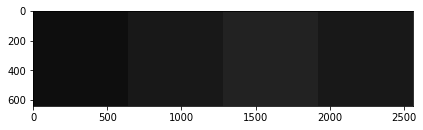

In [31]:
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import copy

# Trainierten Klassifizierer mit Bilddatei testen, in diesem Fall sind es Bilder, die der Klassifizierer schon kennt, 
# allerdings wollte ich hier demonstrieren, wie man gleiche Texturen einfärben würde und das Ergebnis des Klassifizierers
# ist nicht so wichtig
segment = io.imread("test.jpeg")[:,:,0]
segment = rgb2gray(segment)
segs = copy.deepcopy(segment)
segment_list = []
# Bild in Abschnitte aufteilen, normalerweise würde man hier eher sehr kleine Bereiche nehmen, da die Texturen
# ja nicht in diesen Formen auftreten, sondern bspw. in einem Bild ein Stück Wiese und daran ein See mit Wasser usw...
# und man würde die Grenzen möglichst genau erwischen wollen
for i in range(0, segment.shape[0], 640):
    for j in range(0, segment.shape[1], 640):
        segment_list.append(segment[i:i+640, j:j+640])
#saveseg = copy.deepcopy(segment_list)
# Features berechnen und klassifizieren
features =[getharalick(image) for image in segment_list]
y_pred = gnb.predict(np.asarray(features).reshape(-1, 4*13))

# Bildbereiche je nach Textur einfärben, jede Textur hat eine eigene Farbe, dafür habe ich einfach den Grauwert der
# Featurenummer benutzt
for index,item in enumerate(segment_list):
    for ind, it in enumerate(item):
        segment_list[index][ind] = y_pred[index]
io.imshow(np.hstack(segment_list),cmap=plt.cm.gray)


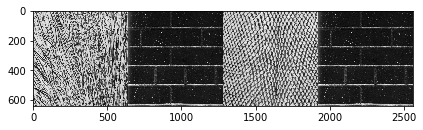

In [32]:
# Originalbild, um Modell zu testen
io.imshow(segs)


[36 72 36]


<ipython-input-33-9c3d3d663a9c>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  segment = rgb2gray(segment)


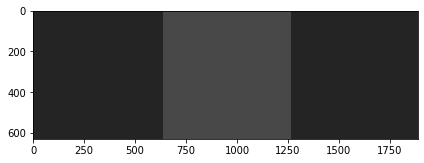

In [33]:
from skimage.color import rgb2gray

# Trainierten Klassifizierer mit Bilddatei testen, allerdings kennt er diese Bilder nicht
segment = io.imread("testfremd.jpeg")[:,:,0]
segment = rgb2gray(segment)
segs = copy.deepcopy(segment)
# Bild in Abschnitte aufteilen, normalerweise würde man hier eher sehr kleine Bereiche nehmen, da die Texturen
# ja nicht in diesen Formen auftreten, sondern bspw. in einem Bild ein Stück Wiese und daran ein See mit Wasser usw...
# und man würde die Grenzen möglichst genau erwischen wollen
segment_list = [segment[:,:638], segment[:,640:1268], segment[:,1269:]]
saveseg = copy.deepcopy(segment_list)
features =[getharalick(image) for image in segment_list]
y_pred = gnb.predict(np.asarray(features).reshape(-1, 4*13))
print(y_pred)
for index,item in enumerate(segment_list):
    for ind, it in enumerate(item):
        segment_list[index][ind] = y_pred[index]
io.imshow(np.hstack(segment_list),cmap=plt.cm.gray)


# Auf den ersten Blick, sieht das Ergebnis ganz gut aus, er hat die gleichen Texturen auch als gleiche erkannt

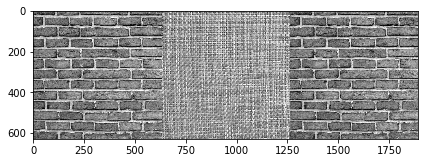

In [34]:
# Originalbild
io.imshow(segs)

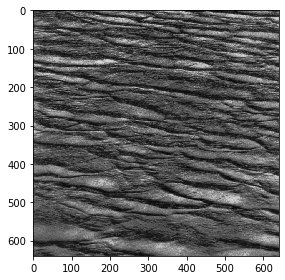

In [35]:
# Schaut man allerdings, welche Texturen gefunden wurde, ist das eher enttäuschend. ;-)
io.imshow(image_list[36])

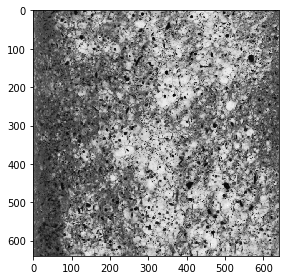

In [36]:
io.imshow(image_list[72])